# Breast Cancer Screening

# Predicting whether a mammogram mass is benign or malignant
***

## Table of contents
1. [Introduction](#introduction)
    1. [Loading Libraries](#libraries)
    2. [Acquiring Data](#acquire)
    3. [Data Content](#content)
    4. [Missing Values](#missing)
    5. [Changing Data Types](#datatypes)
2. [Exploratory Data Analysis](#EDA)
    1. [Feature Visualization](#features)
3. [Data Cleaning](#dataclean)
    1. [BI-RADS](#bi-rads)
    2. [High Confidence](#confidence)
    3. [Non-Predictive](#nonpredictive)
4. [Modeling](#modeling)
    1. [Loading Libraries](#libs)
    2. [Save Data](#save)
    3. [Scale and Split Data](#scalesplit)
    4. [KNN](#knn)
    5. [Logistic Regression](#logistic)
    6. [Naive Bayes](#bayes)
    7. [Support Vector Machine](#svm)
    8. [Random Forest](#forest)
    9. [Neural Network](#nn)
5. [Conclusion](#conclusion)
    1. [Results](#results)
    2. [Recommendations](#recommendations)

## 1. Introduction <a name="introduction"></a>
***

Breast cancer is the most common cancer diagnosed in women worldwide accounting for [25% of all cases](https://en.wikipedia.org/wiki/Breast_cancer). It is more than 100 times more common in women than in men. Breast cancer screening attempts to achieve an early diagnosis of the disease so that the outcomes are better for the patient. There are several types of breast cancer screening such as mammography, genetic screening, ultrasound, and magnetic resonance imaging.

In this case, the project will focus on mammography which is considered the most effective method for detecting breast cancer. The problem is that the low positive predictive value of breast 
biopsy resulting from mammogram interpretation leads to approximately 
70% unnecessary biopsies with benign outcomes. So the goal is to reduce the high number of unnecessary breast biopsies

Physicians and hospitals around the world can use such a model to predict whether a mammogram mass is benign or malignant. Patients can have a better diagnosis and avoid unnecessary biopsies. Better predictions can help both the physician and patient to reduce costs in case of negligence due to unnecessary expenses or lawsuits due to wrong diagnosis.

The [Mammographic Mass Data Set](https://archive.ics.uci.edu/ml/datasets/Mammographic+Mass) has been acquired from the UCI repository. This data contains 961 instances of masses detected in mammograms, and contains the following attributes:

1.	BI-RADS assessment: 1 to 5 (ordinal)
2.	Age: patient's age in years (integer)
3.	Shape: mass shape: round=1 oval=2 lobular=3 irregular=4 (nominal)
4.	Margin: mass margin: circumscribed=1 microlobulated=2 obscured=3 ill-defined=4 spiculated=5 (nominal)
5.	Density: mass density high=1 iso=2 low=3 fat-containing=4 (ordinal)
6.	Severity: benign=0 or malignant=1 (binominal)

A supervised classification algorithm is a good choice to build a predictive model of a set of categories, in this case, benign or malignant. The dataset contains missing values so the first step will be to take care of them. Exploratory data analysis will help understand the data and find some patterns. Finally, different algorithmic models will be used to find the best accuracy possible; this includes neural networks.

### Loading libraries <a name= "libraries"></a>
***
These are some of the libraries used for data wrangling and EDA.

In [398]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

%matplotlib inline
%pylab inline

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (17.5, 10),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}

pylab.rcParams.update(params)
plt.style.use(['seaborn-white'])

Populating the interactive namespace from numpy and matplotlib


### Acquiring data <a name= "acquire"></a>
***
The data was acquired from the UCI repository called [Mammographic Mass Data Set](https://archive.ics.uci.edu/ml/datasets/Mammographic+Mass). Let's look at the data.

In [399]:
data = pd.read_csv('mammographic_masses.data.txt',
                   na_values=['?'],
                   names=['bi-rads','age','shape','margin','density','severity'])
data.head()

,bi-rads,age,shape,margin,density,severity
0,5.0,67.0,3.0,5.0,3.0,1
1,4.0,43.0,1.0,1.0,NaN,1
2,5.0,58.0,4.0,5.0,3.0,1
3,4.0,28.0,1.0,1.0,3.0,0
4,5.0,74.0,1.0,5.0,NaN,1


It was neccessary to deal with the '?' in the data and set them as NaN values. As well, the names of the columns were missing so they were added for better understanding of the data.

### Data content <a name="content"></a>
***
Let's look at the content of the data such as shape, columns, and summary statistics. 

In [400]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 961 entries, 0 to 960
Data columns (total 6 columns):
bi-rads     959 non-null float64
age         956 non-null float64
shape       930 non-null float64
margin      913 non-null float64
density     885 non-null float64
severity    961 non-null int64
dtypes: float64(5), int64(1)
memory usage: 45.1 KB


In [401]:
data.shape

(961, 6)

In [402]:
data.columns

Index(['bi-rads', 'age', 'shape', 'margin', 'density', 'severity'], dtype='object')

The data has 961 entries and 6 different columns. As mentioned before, it does have some missing values so let's looking at them.

### Missing Values <a name="missing"></a>
***
Let's calculate the fraction of missing values per column. This will give us an idea if there is a need to drop columns or rows.

In [403]:
data.isnull().sum()/len(data)*100

bi-rads     0.208117
age         0.520291
shape       3.225806
margin      4.994797
density     7.908429
severity    0.000000
dtype: float64

The density column is the one missing the most values at 7.9%. Only severity column has all the complete data. The question lies in if the entries with missing data should be immediately dropped. Before dropping let's analyze the data and see if no biased is added due to dropping the columns. If it is, then filling in the missing data would be a better solution.

In [404]:
missing = data.loc[(data['age'].isnull()) | (data['shape'].isnull()) |
        (data['margin'].isnull()) | (data['density'].isnull())]
missing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 130 entries, 1 to 923
Data columns (total 6 columns):
bi-rads     129 non-null float64
age         125 non-null float64
shape       99 non-null float64
margin      82 non-null float64
density     54 non-null float64
severity    130 non-null int64
dtypes: float64(5), int64(1)
memory usage: 7.1 KB


The data is already only 961 entries and if missing values are dropped, 13.5% of the data will be gone. However, since in this case the problem is one with a person at risk, the decision is to drop the value and use accurate data for the modeling. 

In [405]:
data.dropna(inplace=True)

In [406]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 830 entries, 0 to 960
Data columns (total 6 columns):
bi-rads     830 non-null float64
age         830 non-null float64
shape       830 non-null float64
margin      830 non-null float64
density     830 non-null float64
severity    830 non-null int64
dtypes: float64(5), int64(1)
memory usage: 45.4 KB


In [407]:
data.describe()

,bi-rads,age,shape,margin,density,severity
count,830.000000,830.000000,830.000000,830.000000,830.000000,830.000000
mean,4.393976,55.781928,2.781928,2.813253,2.915663,0.485542
std,1.888371,14.671782,1.242361,1.567175,0.350936,0.500092
min,0.000000,18.000000,1.000000,1.000000,1.000000,0.000000
25%,4.000000,46.000000,2.000000,1.000000,3.000000,0.000000
50%,4.000000,57.000000,3.000000,3.000000,3.000000,0.000000
75%,5.000000,66.000000,4.000000,4.000000,3.000000,1.000000
max,55.000000,96.000000,4.000000,5.000000,4.000000,1.000000


Now the data has 830 entries with no missing values. Most of the data types are floats so let's make sure all the data has the same data type. 

### Changing data types <a name="datatypes"></a>
***
The only column that is integer type is *severity* so let's change its data type to float.

In [408]:
data['severity'] = data['severity'].astype(float)

In [409]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 830 entries, 0 to 960
Data columns (total 6 columns):
bi-rads     830 non-null float64
age         830 non-null float64
shape       830 non-null float64
margin      830 non-null float64
density     830 non-null float64
severity    830 non-null float64
dtypes: float64(6)
memory usage: 45.4 KB


Now all the data is one data type and will be easier to work with.

# 2. Exploratory Data Analysis <a name="EDA"></a>
***
Let's do EDA to find patterns and understand the data.

### Feature Visualization <a name="features"></a>
***
First, let's look at the target column *severity*.

In [410]:
data['severity'].value_counts()

0.0    427
1.0    403
Name: severity, dtype: int64

Text(0.5,1,'Severity Count Plot')

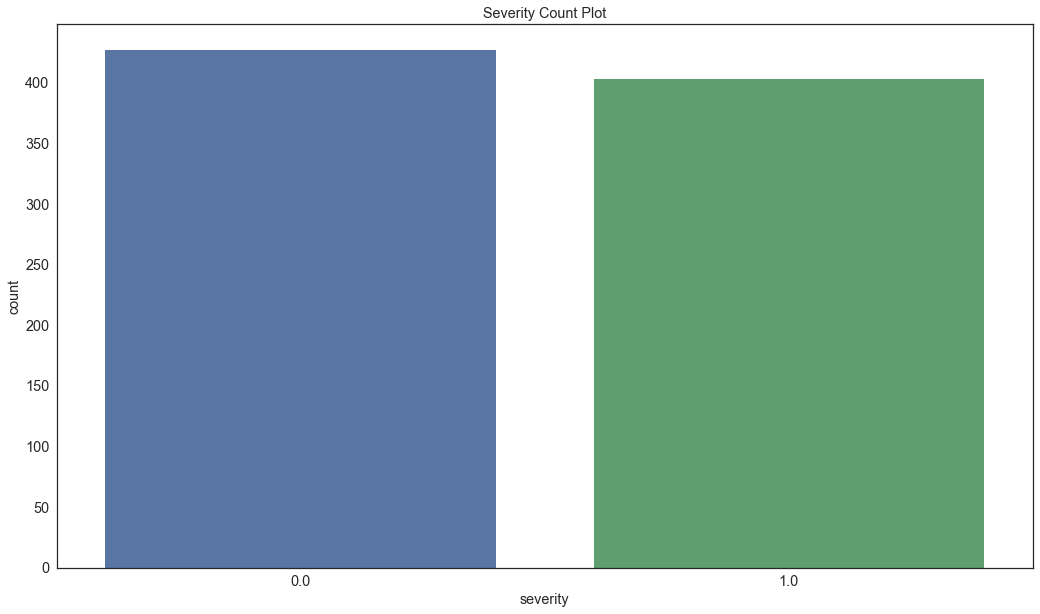

In [411]:
sns.countplot(x='severity',data=data)
plt.title('Severity Count Plot')

Slightly more mammographic mass lesions were diagnosed as benign. To be more specific, the data contains 427 patients with benign lesions and 403 with malignant.

Now let's look at the distribution of patients' age.

Text(0,0.5,'Count')

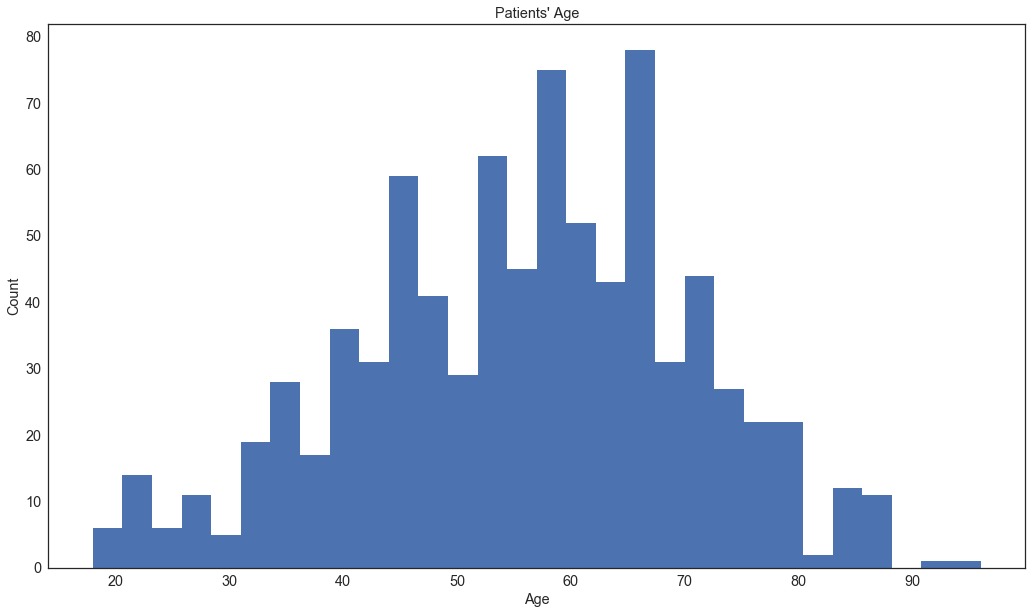

In [412]:
_ = plt.hist(data['age'],bins=30)
plt.title('Patients\' Age')
plt.xlabel('Age')
plt.ylabel('Count')

The histogram looks like the age of patients is normally distributed. Some important takeaways from the graph are: 

- Most of the patients tend to be between 40 and 80 years old.
- Some of the patients are getting screened at an early age.

Now let's look how the difference between bening  and malignant by age and compare them.

Text(0,0.5,'Count')

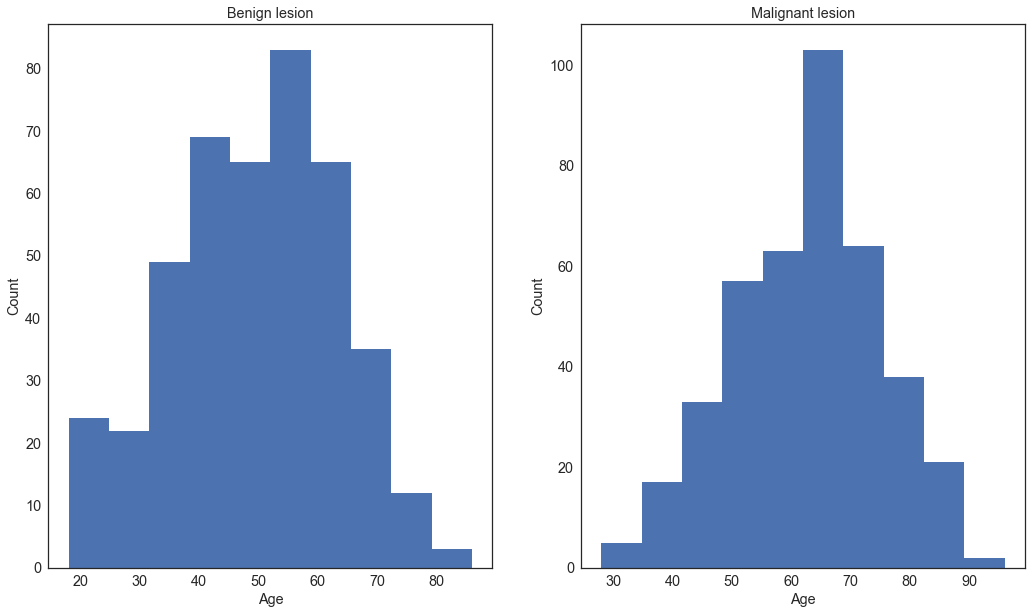

In [413]:
plt.subplot(1,2,1)
benign = data[data['severity']==0]
_ = plt.hist(benign['age'])
plt.title('Benign lesion')
plt.xlabel('Age')
plt.ylabel('Count')

plt.subplot(1,2,2)
malignant = data[data['severity']==1]
_ = plt.hist(malignant['age'])
plt.title('Malignant lesion')
plt.xlabel('Age')
plt.ylabel('Count')

The benign lesions looks right-skewed and malignant lesion looks symmetrical. 

- Most malignant lesions were diagnosed between 60 and 70 years old. 
- Most patients start there diagnose at an early age, 30's. 
- According to the data, some patients were diagnosed with malignant lesions in there 30's.  

Now it is time to look at the shape of the lesions. The shape of the lesion can be the following: 

- mass shape: round=1 oval=2 lobular=3 irregular=4 

So let's look what the shape data tells.

Text(0.5,0,'Shape')

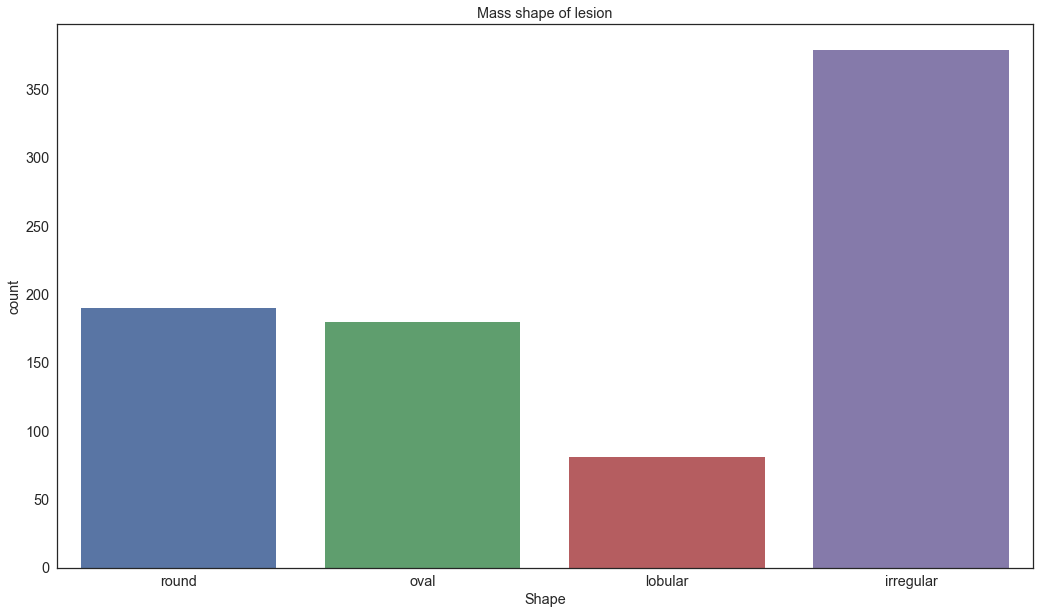

In [414]:
g = sns.countplot(x='shape',data=data)
g.set_xticklabels(['round','oval','lobular','irregular'])
plt.title('Mass shape of lesion')
plt.xlabel('Shape')

The graph shows that most of the lesions had an irregular shape. The least amount of them had a lobular shape. 

Let's see how severity is related to the shape of each lession. 

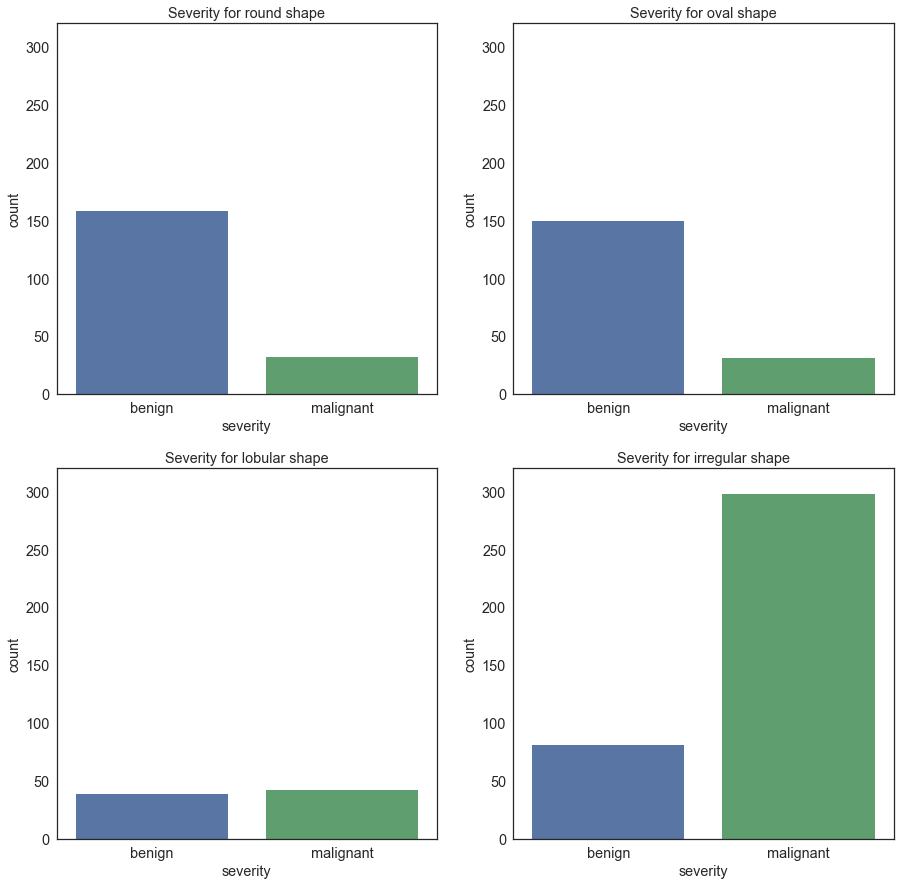

In [415]:
shapes = ['round','oval','lobular','irregular']
plt.figure(figsize=(15,15))
for i in range(1,5):
    plt.subplot(2,2,i)
    g = sns.countplot(x='severity',data=data[data['shape']==i])
    g.set_xticklabels(['benign','malignant'])
    plt.title('Severity for ' + shapes[i-1] + ' shape')
    plt.ylim(0,320)

The 4 graphs show a better relationship between the severity of the lesion and the shape that the lesion has. The following are some of the takeaways:

- Most of malignant lesions tend to be of irregular shape. However, there is still some of irregular shape lesions that can be benign.
- Round and oval lesions tend to be benign.
- There are not many lobular shape lesions; however, it looks like there is 50% chance of beign malignant or benign.

Now let's take a look at the mass margin of the lesion. 

Text(0.5,0,'Margin')

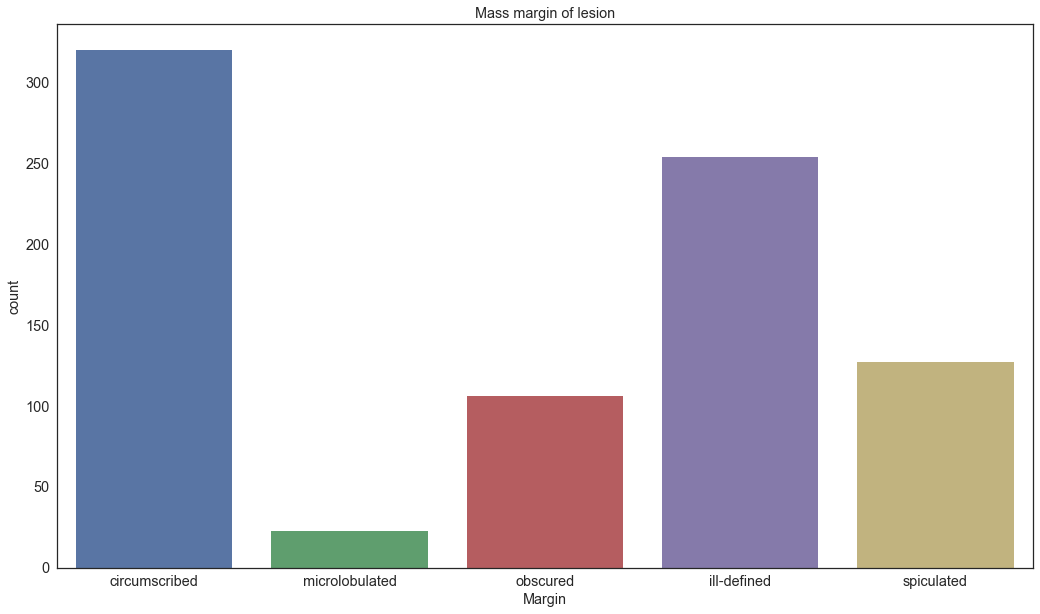

In [416]:
margin = ['circumscribed','microlobulated','obscured',
                   'ill-defined', 'spiculated']
g = sns.countplot(x='margin',data=data)
g.set_xticklabels(margin)
plt.title('Mass margin of lesion')
plt.xlabel('Margin')

- Most of the lesions are circumscribed or ill-defined.
- There is only a few lesions that are microlobulated.

Let's see how the mass margin is related to the severity of the lesion.

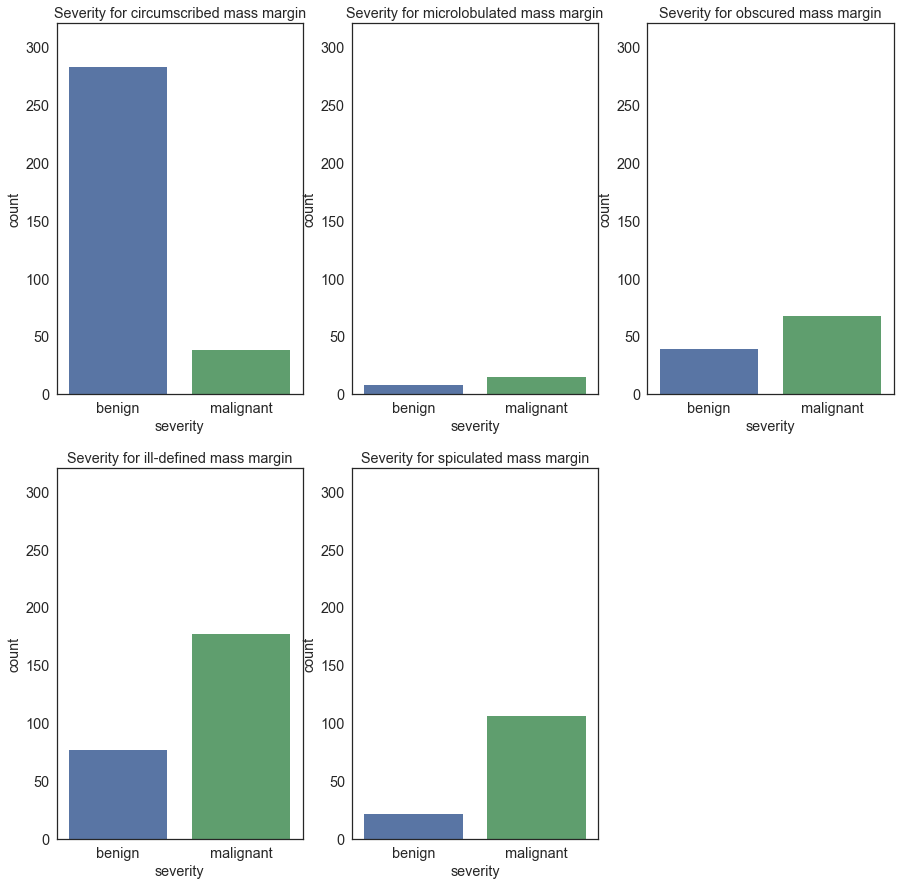

In [417]:
plt.figure(figsize=(15,15))
for i in range(1,6):
    plt.subplot(2,3,i)
    g = sns.countplot(x='severity',data=data[data['margin']==i])
    g.set_xticklabels(['benign','malignant'])
    plt.title('Severity for ' + margin[i-1] + ' mass margin')
    plt.ylim(0,320)

- Even though most of the lesions are circumscribed, they tend to be benign.
- If the mass margin is ill-defined or spiculated, it tends to be malignant. 
- As for obscured or microbulated, the lesions are almost 50% chance of being classified malignant or benign.

At last, let's go over the lesion's mass density and see how it is related to the target variable *severity*.

Text(0.5,0,'Density')

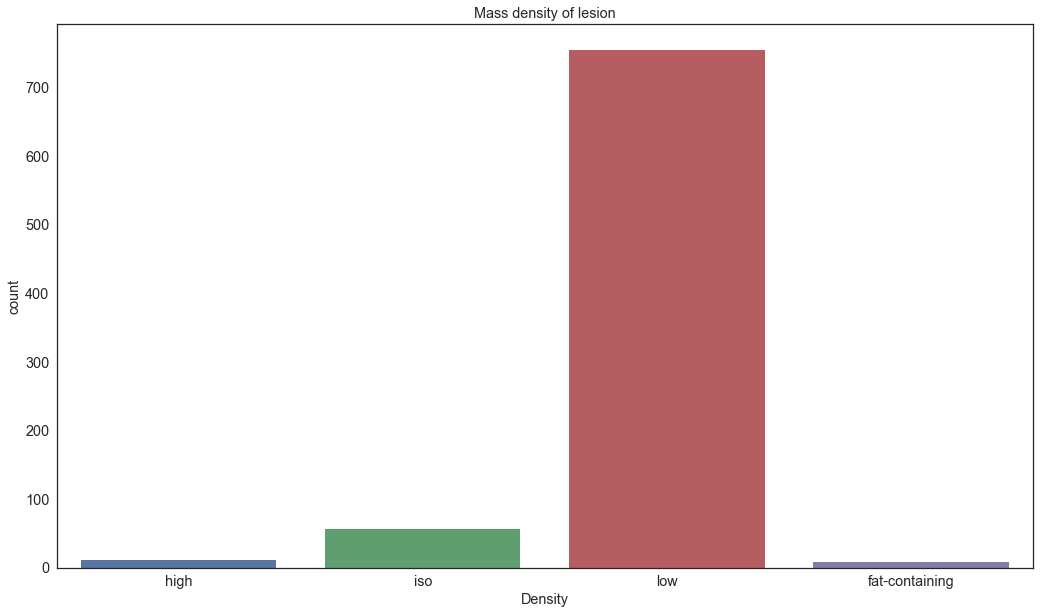

In [418]:
density = ['high','iso','low','fat-containing']
g = sns.countplot(x='density',data=data)
g.set_xticklabels(density)
plt.title('Mass density of lesion')
plt.xlabel('Density')

A majority of the patients had a lesion with low mass density. Now let's see the relationship between mass density and severity.

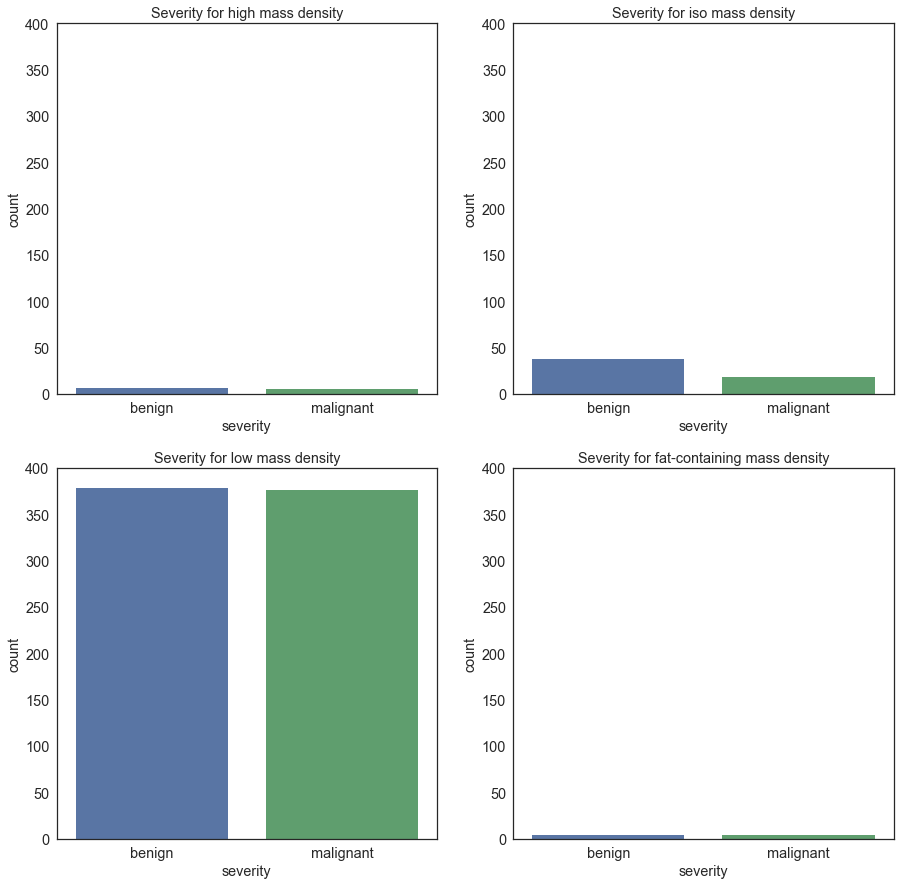

In [419]:
plt.figure(figsize=(15,15))
for i in range(1,5):
    plt.subplot(2,2,i)
    g = sns.countplot(x='severity',data=data[data['density']==i])
    g.set_xticklabels(['benign','malignant'])
    plt.title('Severity for ' + density[i-1] + ' mass density')
    plt.ylim(0,400)

It looks like no conclusion can be made depending on the mass density. Almost all of the lesions were low density; however, 50% of the lesions were classified as benign. 

Now let's look at BI-RADS feature which is how confident the severity classification is.

Text(0.5,0,'BI-RADS')

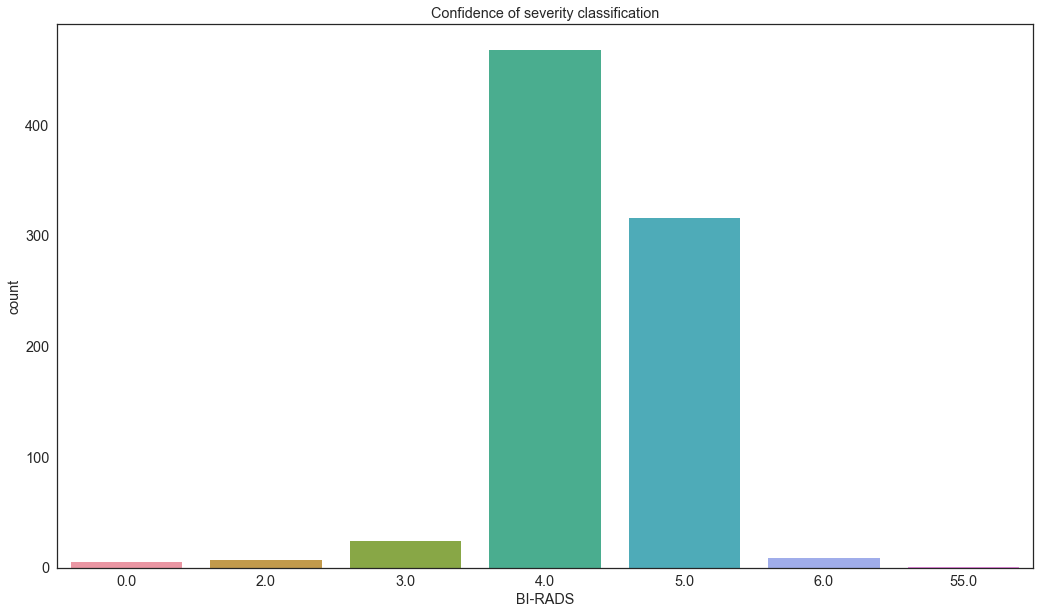

In [420]:
sns.countplot(x='bi-rads',data=data)
plt.title('Confidence of severity classification')
plt.xlabel('BI-RADS')

In [421]:
data['bi-rads'].value_counts()

4.0     468
5.0     316
3.0      24
6.0       9
2.0       7
0.0       5
55.0      1
Name: bi-rads, dtype: int64

The scale of BI-RADS feature has to be from 0 to 5. However, the data has values of 6 and 55. It is necessary to drop them since they are only 10 entries and it is not possible to know if only the BI-RADS was entered incorrectly or the whole entry.

Also, the data shows that most of the severity classifications have a high confidence of 4 and 5. In this case, let's just work with the entries of high confidence.

# 3. Data Cleaning
***
EDA helped to visualize and have a good understanding of the data. The aim here is to remove data with low confidence of classification results as well as errors in the data. Removing the inconsistent data will help our model have a better performance. Let's look at some of the cases found thanks to EDA.

### BI-RADS <a name="bi-rads"></a>
***
The scale for BI-RADS has to be between 0 and 5. However, the data contains entries with values of 6 and 55. Since in this case it is hard to know what happened with the data, let's drop them.

In [422]:
bi = data[data['bi-rads']>5]
bi.head()

,bi-rads,age,shape,margin,density,severity
340,55.0,46.0,4.0,3.0,3.0,1.0
550,6.0,80.0,4.0,5.0,3.0,1.0
664,6.0,60.0,3.0,5.0,3.0,1.0
692,6.0,51.0,4.0,4.0,3.0,1.0
707,6.0,41.0,2.0,1.0,3.0,0.0


In [423]:
data.drop(bi.index,inplace=True)

### High Confidence <a name="confidence"></a>
***
To improve accuracy, let's use data with high confidence of severity classification. This means that only rows with BI-RADS value of 4 and up will be used for modeling.

In [424]:
data = data[data['bi-rads']>=4]

In [425]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 784 entries, 0 to 960
Data columns (total 6 columns):
bi-rads     784 non-null float64
age         784 non-null float64
shape       784 non-null float64
margin      784 non-null float64
density     784 non-null float64
severity    784 non-null float64
dtypes: float64(6)
memory usage: 42.9 KB


The dataset started with 961 instances and after data cleaning, it contains 784 entries.

### Non-Predictive <a name="nonpredictive"> </a>
***
BI-RADS feature helped for data cleaning since it gave the confidence of severity classification. EDA showed that some of the BI-RADS were entered incorrectly and also that most of the entries have high confidence. 

According to the data, BI-RADS is not a predictive attribute so let's drop the column and have the data ready for modeling.

In [426]:
data.drop('bi-rads',axis=1,inplace=True)

In [427]:
data.reset_index(drop=True,inplace=True)

In [428]:
data.head()

,age,shape,margin,density,severity
0,67.0,3.0,5.0,3.0,1.0
1,58.0,4.0,5.0,3.0,1.0
2,28.0,1.0,1.0,3.0,0.0
3,57.0,1.0,5.0,3.0,1.0
4,76.0,1.0,4.0,3.0,1.0


Age, shape, margin, and density attributes are the features that we will build our model with, and "severity" is the classification we will attempt to predict based on those attributes. 

# 4. Modeling <a name="modeling"></a>
***
Let's apply different supervised machine learning techniques to the data set, and see which one yields the highest accuracy as measured with K-Fold cross-validation (k=3) and hyperparameter tuning. Let's use only 3 folds since the dataset is small and the more folds the smaller each fold becomes. 

### Loading libraries <a name="libraries"></a>
***
The project will cover the following techniques:

* KNN
* Logistic Regression
* Naive Bayes
* SVM
* Random forest
* A neural network using Keras.

These are some of the libraries used for modeling.

In [429]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.pipeline import Pipeline

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense

from sklearn.metrics import confusion_matrix, classification_report, f1_score

### Save  Data <a name="save"></a>
***
Now that the dataset is ready let's save it for further reference.

In [430]:
if not os.path.isdir('cleaned_mammographic_data.csv'):
    data.to_csv('cleaned_mammographic_data.csv')

### Scale and Split Data <a name="scalesplit"></a>
***
Now let's preprocess the data and scale it since some of the models require it. As well, the data will be split into 80% for training and 20% for testing. 

In [431]:
X = data.drop('severity',axis=1)
y = data['severity']

In [432]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(X)
scaled_features

array([[ 0.74714206,  0.16557907,  1.381805  ,  0.24002063],
       [ 0.12874507,  0.97187716,  1.381805  ,  0.24002063],
       [-1.93257826, -1.44701711, -1.17172504,  0.24002063],
       ..., 
       [ 0.54100973,  0.97187716,  1.381805  ,  0.24002063],
       [ 0.67843129,  0.97187716,  1.381805  ,  0.24002063],
       [ 0.40358818,  0.16557907,  0.10503998,  0.24002063]])

In [433]:
X_train, X_test, y_train, y_test = train_test_split(scaled_features, y, test_size=0.20, random_state=102)

### KNN <a name="knn"></a>
***
K-Nearest Neighbor classifier is one of the simplest ways to classify data. Given some labeled data points, you are given a new unlabeled data point and the question is what label should it have. The way KNN classification works is that you look at the nearest neighbors of the new data point. Very likely the unlabeled data point should have a similar category(label) to the most data points closest to it. It is like a majority voting of the nearest neighbors of the unlabeled data point.

There is a size of the neighborhood(k) that determines how far the neighbors can be and this value matters since different values can lead to different classification of the unlabeled data. To determine the value k, it is necessary to evaluate the performance of the classifier. As k increases, the decision boundary gets smoother which reduces the variance and increases the bias. 

The first step will be to find the optimal k that minimizes the error. So let's do cross validation to figure this out.



In [434]:
# creating list of K for KNN
myList = list(range(1,50))

# empty list that will hold cv scores
cv_scores = []

# perform 3-fold cross validation
for k in myList:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=3, scoring='accuracy')
    cv_scores.append(scores.mean())

Text(0,0.5,'Misclassification Error')

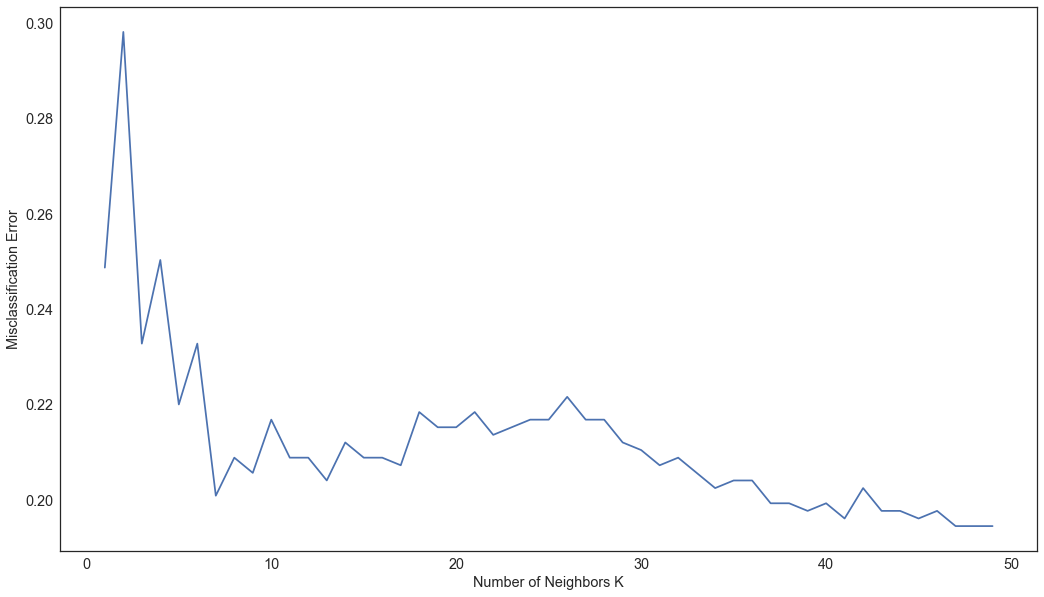

In [435]:
# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# plot misclassification error vs k
plt.plot(myList, MSE)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')

The graph shows that k=7 gives the lowest error with the least amount of neighbors. Now let's try fitting the model with different values of k and make sure 7 is the right value for k.

In [436]:
params = {'n_neighbors':list(range(1,15))}

knn_cv = GridSearchCV(KNeighborsClassifier(),params,cv=3)

In [437]:
%time knn_cv.fit(X_train,y_train)

CPU times: user 278 ms, sys: 9.64 ms, total: 288 ms
Wall time: 271 ms


GridSearchCV(cv=3, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [438]:
%time y_pred = knn_cv.predict(X_test)

print("Best Parameters: {}".format(knn_cv.best_params_)) 
print("Best score is {}".format(knn_cv.best_score_))

CPU times: user 2.84 ms, sys: 904 µs, total: 3.74 ms
Wall time: 2.54 ms
Best Parameters: {'n_neighbors': 7}
Best score is 0.7990430622009569


As expected, the best k value is 7. The best score for KNN is **0.7990**.

In [439]:
def results(X_test,y_test,y_pred,model):
    print("#####################")
    print("Test data")
    print("#####################")
    print("Model Accuracy: {:.2f}%".format(100*model.score(X_test, y_test)))
    print("#####################")
    print("F1 Score: ", f1_score(y_test, y_pred))
    print("#####################")
    print(classification_report(y_test, y_pred))
    print("#####################")
    conf_matrix = confusion_matrix(y_test, y_pred)
    df_cm = pd.DataFrame(conf_matrix, range(2),range(2))
    sns.set(font_scale=1.4) #for label size
    sns.heatmap(df_cm, cmap='Blues',annot=True,annot_kws={"size": 36})

#####################
Test data
#####################
Model Accuracy: 74.52%
#####################
F1 Score:  0.775280898876
#####################
             precision    recall  f1-score   support

        0.0       0.79      0.64      0.71        75
        1.0       0.72      0.84      0.78        82

avg / total       0.75      0.75      0.74       157

#####################


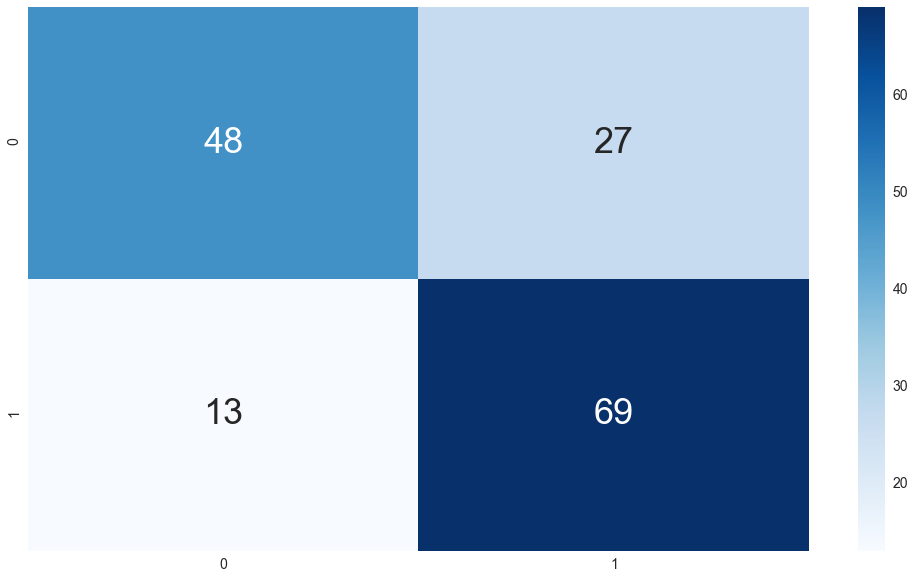

In [440]:
results(X_test,y_test,y_pred,knn_cv)

The classification report shows that 75 entries of the test data were *severity benign(0) * and 82 entries were *severity malignant(1)*. 

The diagonal elements of the confusion matrix show the correct classification of the test data. The off-diagonal elements provide the misclassifications. So the model classfied correctly 117 lesions and misclassified 40.

As shown in the classification report, the recall which is TP/P for benign lesions equals 48/75 or 0.64. As for malignant lesions, the recall equals 69/82 or 0.84. This means malignant lesions are better indentified.

With KNN 13 patients were diagnosed with benign lesion and in fact the lesion was malignant. Also, 27 patients were diagnosed malignant but it was benign. 

### Logistic Regression <a name= "logistic"></a>
***
In logistic regression, the goal is to predict a probability between 0 and 1. In this case, the model will predict the probability of the lesion being malignant. So as the probability increases, the lesion will be more likely to be malignant. The Sigmoid function helps the model to have values only between 0 and 1. So let's set a cutoff point at 0.5, and anything below it results in class 0(benign), anything above is class 1(malignant). 

To get better results using logitic regression, let's tune the parameter *C* which is the inverse of the regularization strength. Regularization is a way to select a preferred level of model complexity so that the model is better at predicting. For example, if the model is too complex, it may overfit, and if its too simple, it may underfit. So the predictions of the model are poor. So in this case, if C is higher, there is an increase in the regularization strength which will make the model to underfit. If C is low, the model will have a greater complexity and it will overfit the data.

$$ C = \frac{1}{\lambda} $$

Where:

- C: is the inverse regularization
- $\lambda$: regularization

In [441]:
param = {'C': [0.0001,0.001,0.01,0.1,1,10,100]}

log_cv = GridSearchCV(LogisticRegression(),param,cv=3,scoring='accuracy')
%time log_cv.fit(X_train,y_train)

CPU times: user 93.2 ms, sys: 10 ms, total: 103 ms
Wall time: 69 ms


GridSearchCV(cv=3, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [442]:
%time y_pred = log_cv.predict(X_test)

print("Best Parameters: {}".format(log_cv.best_params_)) 
print("Best score is {}".format(log_cv.best_score_))

CPU times: user 449 µs, sys: 231 µs, total: 680 µs
Wall time: 473 µs
Best Parameters: {'C': 0.0001}
Best score is 0.8165869218500797


#####################
Test data
#####################
Model Accuracy: 77.71%
#####################
F1 Score:  0.8
#####################
             precision    recall  f1-score   support

        0.0       0.81      0.69      0.75        75
        1.0       0.75      0.85      0.80        82

avg / total       0.78      0.78      0.78       157

#####################


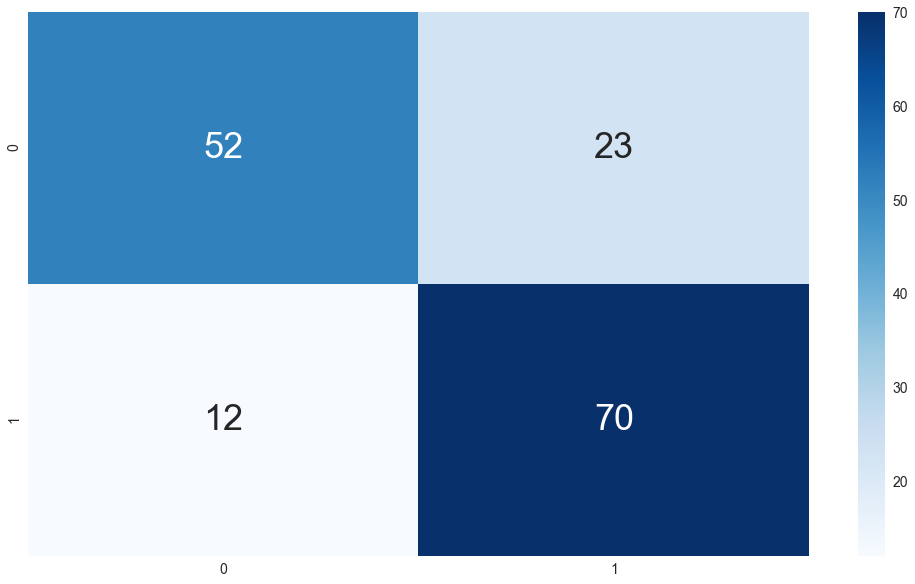

In [443]:
results(X_test,y_test,y_pred,log_cv)

The model accuracy(recall) increased to **77.71%**. 

With Logistic Regression 12 patients were diagnosed with benign lesion and the lesion was malignant, and 23 patients were diagnosed malignant but it was benign.

### Naive Bayes <a name="bayes"></a>
***

The Bayes' theorem is basically conditional probability. The Naive Bayes classifier assumes that the presence of a particular feature in a class is unrelated to the presence of any other feature. Even if the features in a class depend on each other or upon the existence of the other features, all of these properties independently contribute to the probability that the lesion is malignant(in this case) and that is why it is known as ‘Naive’.

$$ P(A|B) = \frac{P(A)P(B|A)}{P(B)}$$

Where:

- P(A|B) is the posterior probability of class (c, target) given predictor (x, attributes).
- P(A) is the prior probability of class.
- P(B|A) is the likelihood which is the probability of predictor given class.
- P(B) is the prior probability of predictor.

The model is useful for very large data sets and in this case the data is small so let's check how it performs. Let's use the Multinomial classifier for multi class prediction. 

The smoothing priors $\alpha$ $\ge$ 0 accounts for features not present in the learning samples and prevents zero probabilities in further computations. Setting $\alpha$ = 1 is called Laplace smoothing, while $\alpha$ < 1 is called Lidstone smoothing.

The features do not need to normalized in this case, but do need to be greater than 0 so let's preprocess the data differently and split it again. 

In [444]:
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(X)
scaled_features

X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(scaled_features, y, test_size=0.20, random_state=102)

In [445]:
param = {'alpha':[0.001,0.01,0.1,1.0]}

nb_cv = GridSearchCV(MultinomialNB(),param,cv=3,scoring='accuracy')
%time nb_cv.fit(X_train_scaled,y_train_scaled)

CPU times: user 50.7 ms, sys: 6.53 ms, total: 57.2 ms
Wall time: 39.3 ms


GridSearchCV(cv=3, error_score='raise',
       estimator=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'alpha': [0.001, 0.01, 0.1, 1.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [446]:
%time y_pred_scaled = nb_cv.predict(X_test_scaled)

print("Best Parameters: {}".format(log_cv.best_params_)) 
print("Best score is {}".format(log_cv.best_score_))

CPU times: user 323 µs, sys: 59 µs, total: 382 µs
Wall time: 326 µs
Best Parameters: {'C': 0.0001}
Best score is 0.8165869218500797


#####################
Test data
#####################
Model Accuracy: 75.80%
#####################
F1 Score:  0.786516853933
#####################
             precision    recall  f1-score   support

        0.0       0.80      0.65      0.72        75
        1.0       0.73      0.85      0.79        82

avg / total       0.76      0.76      0.76       157

#####################


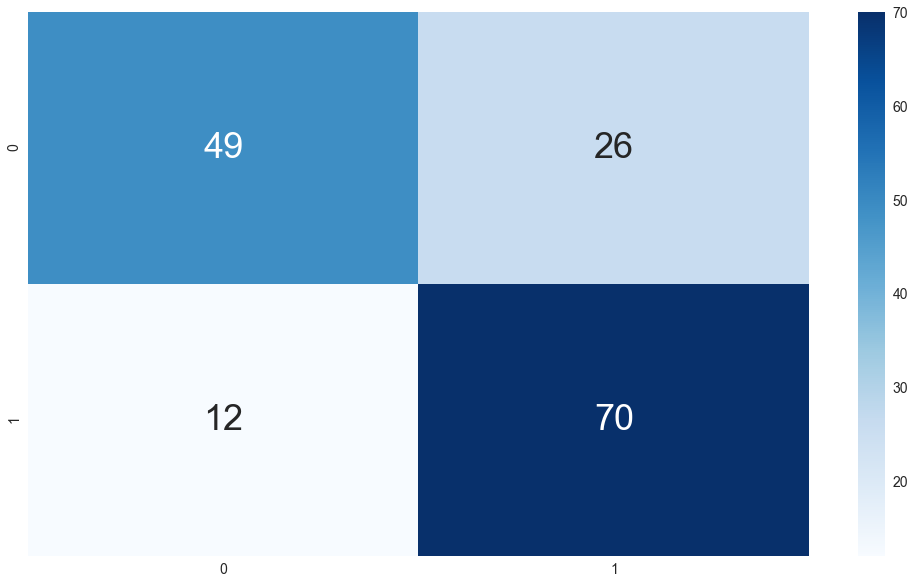

In [447]:
results(X_test_scaled,y_test_scaled,y_pred_scaled,nb_cv)

The model accuracy(recall) slightly decreased to 75.80%.
With Naive Bayes 12 patients were diagnosed with benign lesion and the lesion was malignant, and 26 patients were diagnosed malignant but it was benign.

### Support Vector Machine <a name="svm"></a>
***
An SVM model is a representation of the data as points in space, mapped so that the examples of the separate categories are divided by a clear gap that is as wide as possible. SVM works well with higher-dimensional data(lots of features). The classifier finds higher-dimensional support vectors accross which to divide the data into groups.

Hyperplanes help to separate the groups in the data. To choose the best hyperplane, it needs to maximize the margin between the classes. The vector point that the margin line touch are called *support vectors*. So one outlier can completely change the hyperplane. Use something called the kernel trick to represent data in higher-dimensional spaces to find hyperplanes that might not be apparent in lower dimensions.

C and gamma are the parameters that can be tuned. The larger gamma is the more variability the model has in the decision boundary. The larger C means less slack(penalizing slack), the decision boundary is less linear. If the model allows less slack, the SVM is really trying to fit the data. If gamma increases, the movel gives more degrees of freedom to actually do so. Just an [example](https://cs.stanford.edu/people/karpathy/svmjs/demo/) of how changing values of C and gamma afect the model.

In [448]:
params = [
  {'C': [0.01,0.1,1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [0.01,0.1,1, 10, 100, 1000], 'gamma': [0.1,0.01,0.001, 0.0001], 'kernel': ['rbf']}
 ]

svm_cv = GridSearchCV(SVC(),params,cv=3,scoring='accuracy')
%time svm_cv.fit(X_train,y_train)

CPU times: user 3.34 s, sys: 54.6 ms, total: 3.39 s
Wall time: 3.47 s


GridSearchCV(cv=3, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'C': [0.01, 0.1, 1, 10, 100, 1000], 'kernel': ['linear']}, {'C': [0.01, 0.1, 1, 10, 100, 1000], 'gamma': [0.1, 0.01, 0.001, 0.0001], 'kernel': ['rbf']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [449]:
%time y_pred = svm_cv.predict(X_test)

print("Best Parameters: {}".format(svm_cv.best_params_)) 
print("Best score is {}".format(svm_cv.best_score_))

CPU times: user 3.57 ms, sys: 2.35 ms, total: 5.92 ms
Wall time: 3.23 ms
Best Parameters: {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
Best score is 0.8118022328548644


#####################
Test data
#####################
Model Accuracy: 77.71%
#####################
F1 Score:  0.804469273743
#####################
             precision    recall  f1-score   support

        0.0       0.83      0.67      0.74        75
        1.0       0.74      0.88      0.80        82

avg / total       0.79      0.78      0.77       157

#####################


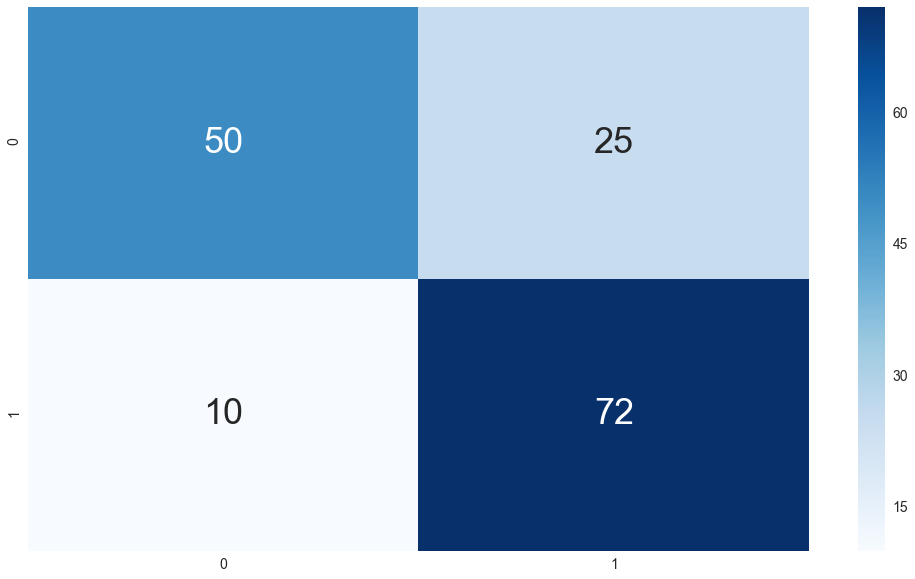

In [450]:
results(X_test,y_test,y_pred,svm_cv)

The model accuracy(recall) is similar logistic regression at 77.71%. With SVMs 10 patients were diagnosed with benign lesion and the lesion was malignant, and 25 patients were diagnosed malignant but it was benign. This means FN(False negatives) decreased and less patients will be actually sick and not be sent for more tests. 

### Random Forest <a name="forest"> </a>
***
Random Forest generates bootstrap training samples (sample with replacement from the data set), and for each one it creates a tree. However, it doesn't just randomize the training samples, it also randomizes a set of predictors allowed to use each time a split is considered which is called bagging. It is harder to interpret but the predictive accuracy tends to be a lot better than compared to doing it just for one tree and superior to other methods as well.

- max_features: the number of features to consider when looking for the best split. Usually the default works so for simplicity let's use only 'auto'.
- n_estimators: The number of trees in the forest. Let's use lower number of trees due to the large amount of data.

In [451]:
params = {'max_features': ['auto','log2','sqrt'],
          'n_estimators': [5, 10, 15, 20]}

forest_cv = GridSearchCV(RandomForestClassifier(),params,cv=3,
                         scoring='accuracy')
%time forest_cv.fit(X_train,y_train)

CPU times: user 820 ms, sys: 18.9 ms, total: 838 ms
Wall time: 820 ms


GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_features': ['auto', 'log2', 'sqrt'], 'n_estimators': [5, 10, 15, 20]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [452]:
%time y_pred = forest_cv.predict(X_test)

print("Best Parameters: {}".format(forest_cv.best_params_)) 
print("Best score is {}".format(forest_cv.best_score_))

CPU times: user 2.1 ms, sys: 81 µs, total: 2.18 ms
Wall time: 2.42 ms
Best Parameters: {'max_features': 'sqrt', 'n_estimators': 5}
Best score is 0.7639553429027113


#####################
Test data
#####################
Model Accuracy: 68.79%
#####################
F1 Score:  0.70303030303
#####################
             precision    recall  f1-score   support

        0.0       0.68      0.67      0.67        75
        1.0       0.70      0.71      0.70        82

avg / total       0.69      0.69      0.69       157

#####################


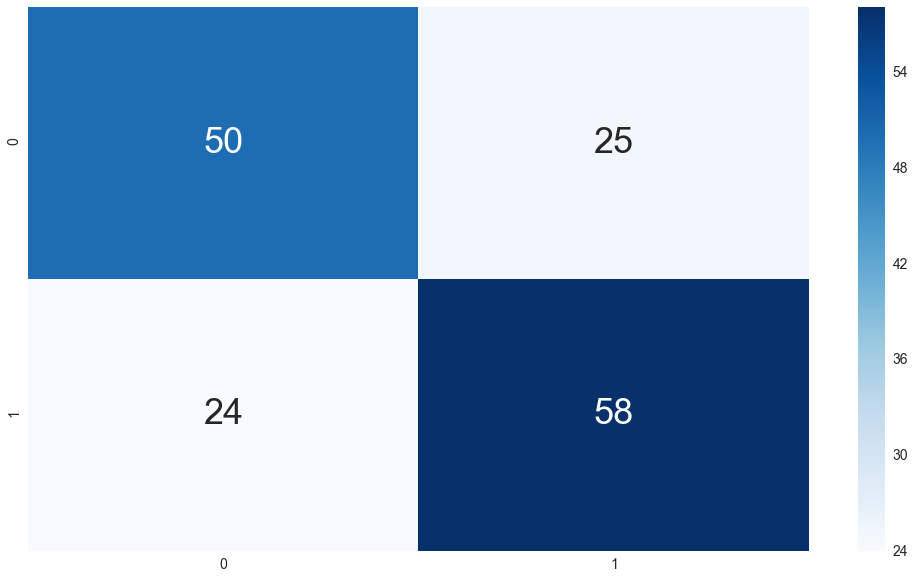

In [453]:
results(X_test,y_test,y_pred,forest_cv)

The model accuracy(recall) is the lowest so far at 70.06%. With Random Forests 25 patients were diagnosed with benign lesion and the lesion was malignant, and 22 patients were diagnosed malignant but it was benign. 

### Neural Networks <a name="nn"></a>
***


In [454]:
y_train_matrix = to_categorical(y_train)
y_test_matrix = to_categorical(y_test)

In [455]:
n_cols = X_train.shape[1]
input_shape=(n_cols,)

In [456]:
def build_model(optimizer):
    model = Sequential()
    model.add(Dense(4,activation='relu',input_shape = input_shape))
    model.add(Dense(2, activation='softmax'))
    model.compile(loss='binary_crossentropy',
             optimizer=optimizer,
             metrics=['accuracy'])
    return model

In [457]:
from keras.wrappers.scikit_learn import KerasClassifier

In [472]:
estimator = KerasClassifier(build_model)

In [473]:
params = {'epochs': [10,20,30],
          'optimizer': ['adam', 'rmsprop']}

keras_cv = GridSearchCV(estimator,params,cv=3)

In [474]:
%time keras_cv.fit(X_train,y_train_matrix)

Epoch 1/10
418/418 [==============================] - 1s 3ms/step - loss: 0.7868 - acc: 0.4713
Epoch 2/10
418/418 [==============================] - 0s 122us/step - loss: 0.7633 - acc: 0.4689
Epoch 3/10
418/418 [==============================] - 0s 118us/step - loss: 0.7428 - acc: 0.4713
Epoch 4/10
418/418 [==============================] - 0s 124us/step - loss: 0.7263 - acc: 0.4880
Epoch 5/10
418/418 [==============================] - 0s 122us/step - loss: 0.7116 - acc: 0.5120
Epoch 6/10
418/418 [==============================] - 0s 120us/step - loss: 0.6991 - acc: 0.5311
Epoch 7/10
418/418 [==============================] - 0s 116us/step - loss: 0.6873 - acc: 0.5550
Epoch 8/10
418/418 [==============================] - 0s 107us/step - loss: 0.6764 - acc: 0.5766
Epoch 9/10
418/418 [==============================] - 0s 125us/step - loss: 0.6671 - acc: 0.5933
Epoch 10/10
418/418 [==============================] - 0s 59us/step
Epoch 1/10
418/418 [==============================] - 1s 3ms/

418/418 [==============================] - 0s 116us/step - loss: 0.5172 - acc: 0.7632
Epoch 19/20
418/418 [==============================] - 0s 115us/step - loss: 0.5141 - acc: 0.7608
Epoch 20/20
418/418 [==============================] - 0s 56us/step
Epoch 1/20
418/418 [==============================] - 1s 3ms/step - loss: 0.6105 - acc: 0.6304
Epoch 2/20
418/418 [==============================] - 0s 128us/step - loss: 0.5960 - acc: 0.7775
Epoch 3/20
418/418 [==============================] - 0s 124us/step - loss: 0.5838 - acc: 0.7895
Epoch 4/20
418/418 [==============================] - 0s 124us/step - loss: 0.5722 - acc: 0.8014
Epoch 5/20
418/418 [==============================] - 0s 125us/step - loss: 0.5623 - acc: 0.8038
Epoch 6/20
418/418 [==============================] - 0s 129us/step - loss: 0.5532 - acc: 0.7990
Epoch 7/20
418/418 [==============================] - 0s 116us/step - loss: 0.5458 - acc: 0.7990
Epoch 8/20
418/418 [==============================] - 0s 115us/step - l

418/418 [==============================] - 0s 126us/step - loss: 0.5360 - acc: 0.7871
Epoch 18/20
418/418 [==============================] - 0s 121us/step - loss: 0.5277 - acc: 0.7919
Epoch 19/20
418/418 [==============================] - 0s 118us/step - loss: 0.5196 - acc: 0.7919
Epoch 20/20
418/418 [==============================] - 0s 61us/step
Epoch 1/20
418/418 [==============================] - 2s 4ms/step - loss: 0.6800 - acc: 0.4976
Epoch 2/20
418/418 [==============================] - 0s 102us/step - loss: 0.6621 - acc: 0.5215
Epoch 3/20
418/418 [==============================] - 0s 109us/step - loss: 0.6482 - acc: 0.5478
Epoch 4/20
418/418 [==============================] - 0s 104us/step - loss: 0.6345 - acc: 0.5933
Epoch 5/20
418/418 [==============================] - 0s 95us/step - loss: 0.6228 - acc: 0.6364
Epoch 6/20
418/418 [==============================] - 0s 107us/step - loss: 0.6110 - acc: 0.7081
Epoch 7/20
418/418 [==============================] - 0s 106us/step - l

418/418 [==============================] - 0s 120us/step - loss: 0.5418 - acc: 0.7751
Epoch 28/30
418/418 [==============================] - 0s 124us/step - loss: 0.5338 - acc: 0.7751
Epoch 29/30
418/418 [==============================] - 0s 113us/step - loss: 0.5265 - acc: 0.7751
Epoch 30/30
418/418 [==============================] - 0s 57us/step
Epoch 1/30
418/418 [==============================] - 2s 4ms/step - loss: 0.6646 - acc: 0.5909
Epoch 2/30
418/418 [==============================] - 0s 118us/step - loss: 0.6480 - acc: 0.6411
Epoch 3/30
418/418 [==============================] - 0s 119us/step - loss: 0.6331 - acc: 0.6603
Epoch 4/30
418/418 [==============================] - 0s 116us/step - loss: 0.6205 - acc: 0.6675
Epoch 5/30
418/418 [==============================] - 0s 118us/step - loss: 0.6093 - acc: 0.6746
Epoch 6/30
418/418 [==============================] - 0s 123us/step - loss: 0.5975 - acc: 0.6699
Epoch 7/30
418/418 [==============================] - 0s 115us/step - 

418/418 [==============================] - 0s 107us/step - loss: 0.4666 - acc: 0.7990
Epoch 18/30
418/418 [==============================] - 0s 110us/step - loss: 0.4637 - acc: 0.8038
Epoch 19/30
418/418 [==============================] - 0s 111us/step - loss: 0.4616 - acc: 0.8038
Epoch 20/30
418/418 [==============================] - 0s 98us/step - loss: 0.4596 - acc: 0.8062
Epoch 21/30
418/418 [==============================] - 0s 108us/step - loss: 0.4583 - acc: 0.8062
Epoch 22/30
418/418 [==============================] - 0s 106us/step - loss: 0.4569 - acc: 0.8062
Epoch 23/30
418/418 [==============================] - 0s 107us/step - loss: 0.4550 - acc: 0.8086
Epoch 24/30
418/418 [==============================] - 0s 103us/step - loss: 0.4533 - acc: 0.8086
Epoch 25/30
418/418 [==============================] - 0s 111us/step - loss: 0.4520 - acc: 0.8110
Epoch 26/30
418/418 [==============================] - 0s 104us/step - loss: 0.4506 - acc: 0.8110
Epoch 27/30
418/418 [============

GridSearchCV(cv=3, error_score='raise',
       estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x142a04358>,
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'epochs': [10, 20, 30], 'optimizer': ['adam', 'rmsprop']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [475]:
%time y_pred = keras_cv.predict(X_test)

print("Best Parameters: {}".format(keras_cv.best_params_)) 
print("Best score is {}".format(keras_cv.best_score_))

CPU times: user 672 ms, sys: 21.1 ms, total: 693 ms
Wall time: 696 ms
Best Parameters: {'epochs': 20, 'optimizer': 'adam'}
Best score is 0.7942583739662474


In [476]:
def neural_network_results(y_test,y_pred):
    print("#####################")
    print("Test data")
    print("#####################")
    print(classification_report(y_test, y_pred))
    print("#####################")
    conf_matrix = confusion_matrix(y_test, y_pred)
    df_cm = pd.DataFrame(conf_matrix, range(2),range(2))
    sns.set(font_scale=1.4) #for label size
    sns.heatmap(df_cm, cmap='Blues',annot=True,annot_kws={"size": 36})

#####################
Test data
#####################
             precision    recall  f1-score   support

        0.0       0.85      0.69      0.76        75
        1.0       0.76      0.89      0.82        82

avg / total       0.80      0.80      0.79       157

#####################


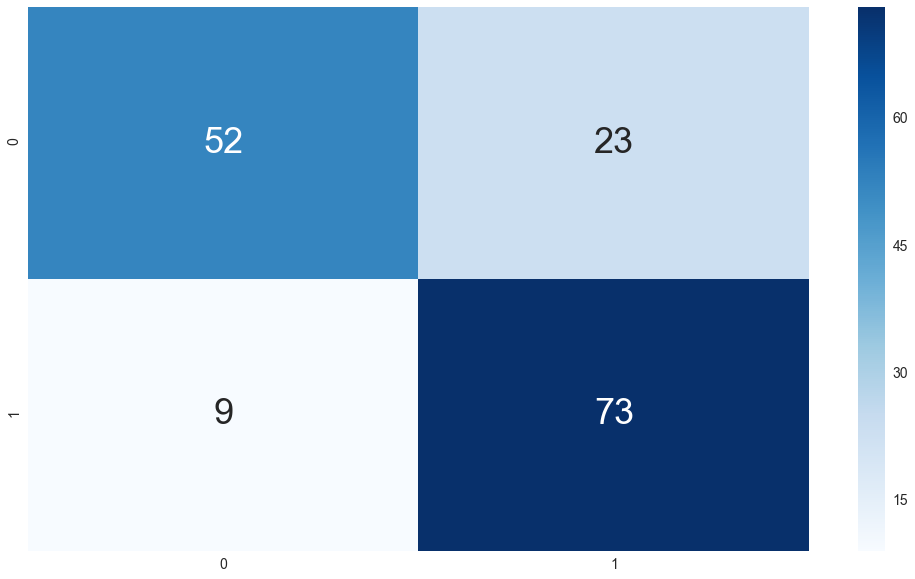

In [477]:
neural_network_results(y_test,y_pred)

A neural network with one hidden layer with 4 nodes had an accuracy of **79.61%**. The best parameters for the NN were 20 epochs with the optimizer 'adam'. Let's try adding more nodes to the hidden layer and see if the results improve.

In [478]:
def build_model(optimizer):
    model = Sequential()
    model.add(Dense(8,activation='relu',input_shape = input_shape))
    model.add(Dense(2, activation='softmax'))
    model.compile(loss='binary_crossentropy',
             optimizer=optimizer,
             metrics=['accuracy'])
    return model

In [479]:
estimator = KerasClassifier(build_model)

In [480]:
params = {'epochs': [10,20,30],
          'optimizer': ['adam', 'rmsprop']}

keras_cv = GridSearchCV(estimator,params,cv=3)

In [481]:
%time keras_cv.fit(X_train,y_train_matrix)

Epoch 1/10
418/418 [==============================] - 2s 4ms/step - loss: 0.7241 - acc: 0.5622
Epoch 2/10
418/418 [==============================] - 0s 131us/step - loss: 0.6901 - acc: 0.6005
Epoch 3/10
418/418 [==============================] - 0s 134us/step - loss: 0.6635 - acc: 0.6866
Epoch 4/10
418/418 [==============================] - 0s 140us/step - loss: 0.6388 - acc: 0.6938
Epoch 5/10
418/418 [==============================] - 0s 158us/step - loss: 0.6169 - acc: 0.7105
Epoch 6/10
418/418 [==============================] - 0s 135us/step - loss: 0.5972 - acc: 0.7177
Epoch 7/10
418/418 [==============================] - 0s 125us/step - loss: 0.5797 - acc: 0.7201
Epoch 8/10
418/418 [==============================] - 0s 126us/step - loss: 0.5656 - acc: 0.7297
Epoch 9/10
418/418 [==============================] - 0s 117us/step - loss: 0.5525 - acc: 0.7249
Epoch 10/10
418/418 [==============================] - 0s 59us/step
Epoch 1/10
418/418 [==============================] - 2s 4ms/

418/418 [==============================] - 0s 176us/step - loss: 0.4942 - acc: 0.7847
Epoch 19/20
418/418 [==============================] - 0s 151us/step - loss: 0.4922 - acc: 0.7847
Epoch 20/20
418/418 [==============================] - 0s 62us/step
Epoch 1/20
418/418 [==============================] - 2s 5ms/step - loss: 0.7005 - acc: 0.5598
Epoch 2/20
418/418 [==============================] - 0s 109us/step - loss: 0.6599 - acc: 0.6196
Epoch 3/20
418/418 [==============================] - 0s 113us/step - loss: 0.6279 - acc: 0.6603
Epoch 4/20
418/418 [==============================] - 0s 134us/step - loss: 0.5984 - acc: 0.7105
Epoch 5/20
418/418 [==============================] - 0s 161us/step - loss: 0.5747 - acc: 0.7249
Epoch 6/20
418/418 [==============================] - 0s 151us/step - loss: 0.5569 - acc: 0.7464
Epoch 7/20
418/418 [==============================] - 0s 135us/step - loss: 0.5412 - acc: 0.7560
Epoch 8/20
418/418 [==============================] - 0s 136us/step - l

418/418 [==============================] - 0s 116us/step - loss: 0.4720 - acc: 0.7919
Epoch 18/20
418/418 [==============================] - 0s 123us/step - loss: 0.4670 - acc: 0.7895
Epoch 19/20
418/418 [==============================] - 0s 110us/step - loss: 0.4625 - acc: 0.7895
Epoch 20/20
418/418 [==============================] - 0s 56us/step
Epoch 1/20
418/418 [==============================] - 2s 4ms/step - loss: 0.9791 - acc: 0.5263
Epoch 2/20
418/418 [==============================] - 0s 108us/step - loss: 0.8788 - acc: 0.5431
Epoch 3/20
418/418 [==============================] - 0s 109us/step - loss: 0.8126 - acc: 0.5526
Epoch 4/20
418/418 [==============================] - 0s 112us/step - loss: 0.7517 - acc: 0.5574
Epoch 5/20
418/418 [==============================] - 0s 115us/step - loss: 0.6999 - acc: 0.5598
Epoch 6/20
418/418 [==============================] - 0s 116us/step - loss: 0.6533 - acc: 0.5885
Epoch 7/20
418/418 [==============================] - 0s 124us/step - 

418/418 [==============================] - 0s 155us/step - loss: 0.4510 - acc: 0.7919
Epoch 28/30
418/418 [==============================] - 0s 157us/step - loss: 0.4480 - acc: 0.7990
Epoch 29/30
418/418 [==============================] - 0s 131us/step - loss: 0.4453 - acc: 0.8014
Epoch 30/30
418/418 [==============================] - 0s 87us/step
Epoch 1/30
418/418 [==============================] - 2s 5ms/step - loss: 0.9121 - acc: 0.4211
Epoch 2/30
418/418 [==============================] - 0s 125us/step - loss: 0.8571 - acc: 0.4330
Epoch 3/30
418/418 [==============================] - 0s 125us/step - loss: 0.8127 - acc: 0.4856
Epoch 4/30
418/418 [==============================] - 0s 125us/step - loss: 0.7701 - acc: 0.5191
Epoch 5/30
418/418 [==============================] - 0s 122us/step - loss: 0.7336 - acc: 0.5383
Epoch 6/30
418/418 [==============================] - 0s 121us/step - loss: 0.7045 - acc: 0.5550
Epoch 7/30
418/418 [==============================] - 0s 121us/step - 

418/418 [==============================] - 0s 129us/step - loss: 0.4932 - acc: 0.8230
Epoch 18/30
418/418 [==============================] - 0s 132us/step - loss: 0.4859 - acc: 0.8278
Epoch 19/30
418/418 [==============================] - 0s 133us/step - loss: 0.4791 - acc: 0.8325
Epoch 20/30
418/418 [==============================] - 0s 139us/step - loss: 0.4730 - acc: 0.8325
Epoch 21/30
418/418 [==============================] - 0s 122us/step - loss: 0.4682 - acc: 0.8278
Epoch 22/30
418/418 [==============================] - 0s 118us/step - loss: 0.4631 - acc: 0.8349
Epoch 23/30
418/418 [==============================] - 0s 121us/step - loss: 0.4583 - acc: 0.8301
Epoch 24/30
418/418 [==============================] - 0s 126us/step - loss: 0.4550 - acc: 0.8301
Epoch 25/30
418/418 [==============================] - 0s 133us/step - loss: 0.4515 - acc: 0.8325
Epoch 26/30
418/418 [==============================] - 0s 125us/step - loss: 0.4486 - acc: 0.8349
Epoch 27/30
418/418 [===========

GridSearchCV(cv=3, error_score='raise',
       estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x14d8db5c0>,
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'epochs': [10, 20, 30], 'optimizer': ['adam', 'rmsprop']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [482]:
%time y_pred = keras_cv.predict(X_test)

print("Best Parameters: {}".format(keras_cv.best_params_)) 
print("Best score is {}".format(keras_cv.best_score_))

CPU times: user 902 ms, sys: 30.3 ms, total: 932 ms
Wall time: 938 ms
Best Parameters: {'epochs': 30, 'optimizer': 'rmsprop'}
Best score is 0.7974481666297243


#####################
Test data
#####################
             precision    recall  f1-score   support

        0.0       0.79      0.71      0.75        75
        1.0       0.76      0.83      0.79        82

avg / total       0.77      0.77      0.77       157

#####################


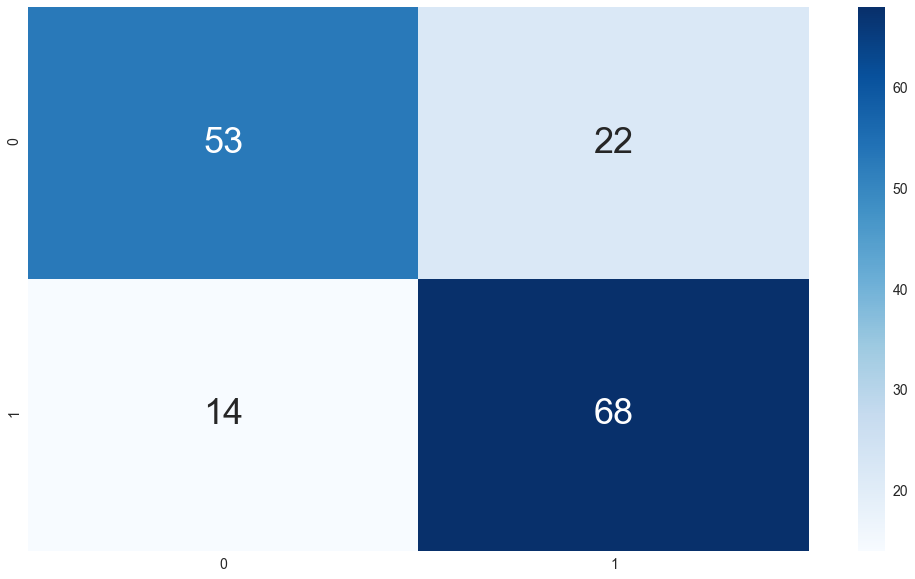

In [483]:
neural_network_results(y_test,y_pred)

By increasing the number of nodes of the hidden layer to 8, the accuracy dropped to **77.07%**. In this case the best parameters were 30 epochs and the rmsprop optimizer.